# MLP class

In [2]:
import numpy as np

In [3]:
import copy

class MLP:
    def __init__(self, layer_sizes, act_fun, out_act_fun_is_linear = True):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.set_act_fun(act_fun)
        self.set_out_act_fun(out_act_fun_is_linear)
        
        self.weights = [None] * (self.n_layers - 1)
        self.biases = [None] * (self.n_layers - 1)
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(self.n_layers - 1):
            self.weights[i] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.random.rand(self.layer_sizes[i + 1], 1)        

    def _forward(self, X, return_activations = False):
        X = np.atleast_2d(X)
        Y = np.atleast_2d([])
        A = []
        for i in range(X.shape[0]):
            Y_temp = np.atleast_2d(X[i]) #if len(X.shape) > 1 else X
            for j in range(len(self.weights) - 1):
                A.append(self.weights[j].T.dot(Y_temp) + self.biases[j])
                Y_temp = self.act_fun(A[-1])
            A.append(self.weights[-1].T.dot(Y_temp) + self.biases[-1])
            Y_temp = self.out_act_fun(A[-1])
            Y = np.append(Y, Y_temp)
        return (Y, A) if return_activations else Y
    
    def predict(self, X):
        return self._forward(X)
    
    def _backward(self, x, y):
        y = np.atleast_2d(y)
        x = np.atleast_2d(x)
        y_pred, A = self._forward(x, return_activations = True)
        error = y_pred - y
        D_weights = []
        D_biases = []
        D = []
        for i in range(len(self.weights) - 1, -1, -1):
            if i == len(self.weights) - 1:
                D.insert(0, error * self.out_act_fun_prime(A[-1]))
            else:
                D.insert(0, np.dot(self.weights[i + 1], D[0]) * self.act_fun_prime(A[i]))
            if i == 0:
                D_weights.insert(0, np.outer(x, D[0]))
            else:
                D_weights.insert(0, np.outer(self.act_fun(A[i - 1]), D[0]))
            D_biases.insert(0, D[0])
        return D_weights, D_biases

    def _momentum_update(self, D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate, batch_size):
        for i in range(len(self.weights)):
            momentum_w[i] = - D_weights[i] / batch_size + momentum_coef * momentum_w[i]
            momentum_b[i] = - D_biases[i] / batch_size + momentum_coef * momentum_b[i]
            self.weights[i] += learning_rate * momentum_w[i]
            self.biases[i] += learning_rate * momentum_b[i]
        return momentum_w, momentum_b
    
    def _RMSProp_update(self, D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate, batch_size):
        for i in range(len(self.weights)):
            D_weights[i] /= batch_size
            D_biases[i] /= batch_size
            E_w[i] = beta * E_w[i] + (1 - beta) * D_weights[i] ** 2
            E_b[i] = beta * E_b[i] + (1 - beta) * D_biases[i] ** 2
            self.weights[i] -= learning_rate * D_weights[i] / (np.sqrt(E_w[i] + epsilon))
            self.biases[i] -= learning_rate * D_biases[i] / (np.sqrt(E_b[i] + epsilon))
        return E_w, E_b
    
    def fit_SGD(self, X, Y, first_lr = 0.01, lr_decay_rate=0, momentum_coef=0.9, epochs = 100, n_epochs_displayed = 100, optimizer=None, beta=0.9, epsilon=1e-8, track_weights=False):
        X = np.array(X)
        Y = np.array(Y)
        losses = []

        if track_weights:
            weights_over_epochs = [copy.deepcopy(self.weights)]
            biases_over_epochs = [copy.deepcopy(self.biases)]
        else:
            weights_over_epochs = []
            biases_over_epochs = []
            
        if optimizer == 'momentum':
            momentum_w = [np.zeros(w.shape) for w in self.weights]
            momentum_b = [np.zeros(b.shape) for b in self.biases]

        if optimizer == 'RMSProp':
            E_w = [np.zeros(w.shape) for w in self.weights]
            E_b = [np.zeros(b.shape) for b in self.biases]

        for epoch in range(epochs):
            permutaion = np.random.permutation(X.shape[0])
            for i in permutaion:
                D_weights, D_biases = self._backward(X[i], Y[i])
                learning_rate = first_lr / (1 + epoch * lr_decay_rate)
            
                if not optimizer:
                    for j in range(len(self.weights)):
                        self.weights[j] -= learning_rate * D_weights[j]
                        self.biases[j] -= learning_rate * D_biases[j]
            
                if optimizer == 'momentum':
                    momentum_w, momentum_b = self._momentum_update(D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate, 1)

                if optimizer == 'RMSProp':
                    E_w, E_b = self._RMSProp_update(D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate, 1)
            
            losses.append(self.mse(self.predict(X), Y))
            if track_weights:
                weights_over_epochs.append(copy.deepcopy(self.weights))
                biases_over_epochs.append(copy.deepcopy(self.biases))
            if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
                print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
        return losses, weights_over_epochs, biases_over_epochs
    
    # def fit_with_momentum(self, X, Y, first_lr = 0.01, lr_decay_rate=0, momentum_coef=0.9, epochs = 100, n_epochs_displayed = 100):
    #     X = np.array(X)
    #     Y = np.array(Y)
    #     losses = []
    #     weights_over_epochs = [copy.deepcopy(self.weights)]
    #     biases_over_epochs = [copy.deepcopy(self.biases)]
    #     momentum_w = [np.zeros(w.shape) for w in self.weights]
    #     momentum_b = [np.zeros(b.shape) for b in self.biases]

    #     sample_size = X.shape[0]

    #     for epoch in range(epochs):
    #         permutaion = np.random.permutation(X.shape[0])
    #         D_weights = [np.zeros(w.shape) for w in self.weights]
    #         D_biases = [np.zeros(b.shape) for b in self.biases]
    #         for i in permutaion:
    #             D_weights_temp, D_biases_temp = self._backward(X[i], Y[i])
    #             learning_rate = first_lr / (1 + epoch * lr_decay_rate)
    #             for j in range(len(self.weights)):
    #                 D_weights[j] -= D_weights_temp[j]
    #                 D_biases[j] -= D_biases_temp[j]
    #         for j in range(len(self.weights)):
    #             momentum_w[j] = D_weights[j] / sample_size + momentum_coef * momentum_w[j]
    #             momentum_b[j] = D_biases[j] / sample_size + momentum_coef * momentum_b[j]
    #             self.weights[j] += learning_rate * momentum_w[j]
    #             self.biases[j] += learning_rate * momentum_b[j]
    #         losses.append(self.mse(self.predict(X), Y))
    #         weights_over_epochs.append(copy.deepcopy(self.weights))
    #         biases_over_epochs.append(copy.deepcopy(self.biases))
    #         if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
    #             print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
    #     return losses, weights_over_epochs, biases_over_epochs
    
    # def fit_with_RMSProp(self, X, Y, first_lr = 0.01, lr_decay_rate=0, beta=0.9, epsilon=1e-8, epochs = 100, n_epochs_displayed = 100):
    #     X = np.array(X)
    #     Y = np.array(Y)
    #     losses = []
    #     weights_over_epochs = [copy.deepcopy(self.weights)]
    #     biases_over_epochs = [copy.deepcopy(self.biases)]
    #     E_w = [np.zeros(w.shape) for w in self.weights]
    #     E_b = [np.zeros(b.shape) for b in self.biases]
    #     for epoch in range(epochs):
    #         permutaion = np.random.permutation(X.shape[0])
    #         D_weights = [np.zeros(w.shape) for w in self.weights]
    #         D_biases = [np.zeros(b.shape) for b in self.biases]
    #         for i in permutaion:
    #             D_weights_temp, D_biases_temp = self._backward(X[i], Y[i])
    #             for j in range(len(self.weights)):
    #                 D_weights[j] += D_weights_temp[j]
    #                 D_biases[j] += D_biases_temp[j]
    #         for j in range(len(self.weights)):
    #             E_w[j] = beta * E_w[j] + (1 - beta) * D_weights[j] ** 2
    #             E_b[j] = beta * E_b[j] + (1 - beta) * D_biases[j] ** 2
    #             self.weights[j] -= first_lr * D_weights[j] / (np.sqrt(E_w[j] + epsilon))
    #             self.biases[j] -= first_lr * D_biases[j] / (np.sqrt(E_b[j] + epsilon))
    #         losses.append(self.mse(self.predict(X), Y))
    #         weights_over_epochs.append(copy.deepcopy(self.weights))
    #         biases_over_epochs.append(copy.deepcopy(self.biases))
    #         if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
    #             print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
    #     return losses, weights_over_epochs, biases_over_epochs
    
    def fit_batch(self, X, Y, first_lr = 0.01, lr_decay_rate=0.01, epochs = 100, n_epochs_displayed = 100):
        X = np.array(X)
        Y = np.array(Y)
        losses = []
        weights_over_epochs = [self.weights]
        biases_over_epochs = [self.biases]
        for epoch in range(epochs):
            permutaion = np.random.permutation(X.shape[0])
            D_weights = [np.zeros(w.shape) for w in self.weights]
            D_biases = [np.zeros(b.shape) for b in self.biases]
            for i in permutaion:
                D_weights_temp, D_biases_temp = self._backward(X[i], Y[i])
                for j in range(len(self.weights)):
                    D_weights[j] += D_weights_temp[j]
                    D_biases[j] += D_biases_temp[j]
            learning_rate = first_lr / (1 + epoch * lr_decay_rate)
            for j in range(len(self.weights)):
                self.weights[j] -= learning_rate * D_weights[j] / X.shape[0]
                self.biases[j] -= learning_rate * D_biases[j] / X.shape[0]
            losses.append(self.mse(self.predict(X), Y))
            weights_over_epochs.append(self.weights)
            biases_over_epochs.append(self.biases)
            if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
                print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
        return losses, weights_over_epochs, biases_over_epochs
    
    def fit_minibatch(self, X, Y, first_lr = 0.01, lr_decay_rate=0.01, epochs = 100, n_epochs_displayed = 100, batch_size = 32):
        X = np.array(X)
        Y = np.array(Y)
        losses = []
        weights_over_epochs = [self.weights]
        biases_over_epochs = [self.biases]
        for epoch in range(epochs):
            permutation = np.random.permutation(X.shape[0])
            for i in range(0, X.shape[0], batch_size):
                D_weights = [np.zeros(w.shape) for w in self.weights]
                D_biases = [np.zeros(b.shape) for b in self.biases]
                for j in range(i, min(i + batch_size, X.shape[0])):
                    D_weights_temp, D_biases_temp = self._backward(X[j], Y[j])
                    for k in range(len(self.weights)):
                        D_weights[k] += D_weights_temp[k]
                        D_biases[k] += D_biases_temp[k]
                learning_rate = first_lr / (1 + epoch * lr_decay_rate)
                for j in range(len(self.weights)):
                    self.weights[j] -= learning_rate * D_weights[j] / batch_size
                    self.biases[j] -= learning_rate * D_biases[j] / batch_size
            losses.append(self.mse(self.predict(X), Y))
            weights_over_epochs.append(self.weights)
            biases_over_epochs.append(self.biases)
            if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
                print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
        return losses, weights_over_epochs, biases_over_epochs
                
    def set_all_weights(self, weights):
        self.weights = weights

    def set_weights_for_layer(self, layer, weights):
        self.weights[layer] = weights

    def set_weigth(self, layer, from_neuron, to_neuron, value):
        self.weights[layer][from_neuron][to_neuron] = value

    def set_all_biases(self, biases):
        self.biases = biases

    def set_biases_for_layer(self, layer, biases):
        self.biases[layer] = biases

    def set_bias(self, layer, neuron, value):
        self.biases[layer][neuron] = value

    def set_act_fun(self, act_fun):
        act_fun_prime = None
        if act_fun == 'sigmoid':
            act_fun = lambda x: 1 / (1 + np.exp(-x))
            act_fun_prime = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

        if act_fun == 'relu':
            act_fun = lambda x: np.maximum(0, x)
            act_fun_prime = lambda x: np.where(x > 0, 1, 0)

        if act_fun == 'tanh':
            act_fun = lambda x: np.tanh(x)
            act_fun_prime = lambda x: 1 - np.tanh(x) ** 2
            
        self.act_fun = act_fun
        self.act_fun_prime = act_fun_prime

    def set_out_act_fun(self, out_act_fun_is_linear):
        if not out_act_fun_is_linear:
            self.out_act_fun = self.act_fun
            self.out_act_fun_prime = self.act_fun_prime
            return
        self.out_act_fun = lambda x: x
        self.out_act_fun_prime = lambda x: 1
    

    def mse(self, y, y_pred):
        return np.mean((y - y_pred) ** 2) / 2

    

In [4]:
def normalize(data, min = None, max = None):
    data = np.array(data)
    if min is None:
        min = np.min(data)

    if max is None:
        max = np.max(data)

    return (data - min) / (max - min), min, max    

In [5]:
def denormalize(data, min, max):
    data = np.array(data)
    return data * (max - min) + min

# Functions for visualisation

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

In [7]:
def draw_network_for_epoch(weights, biases, epoch):
    G = nx.Graph()
    n_layers = len(weights) + 1
    n_neurons = [len(layer) for layer in weights] + [len(biases[-1])]

    max_abs_weight = max([np.max(np.abs(layer)) for layer in weights])

    for i in range(n_layers):
        for j in range(n_neurons[i]):
            G.add_node(f'{i}-{j}')
    for i in range(n_layers - 1):
        for j in range(n_neurons[i]):
            for k in range(n_neurons[i + 1]):
                G.add_edge(f'{i}-{j}', f'{i + 1}-{k}', weight=weights[i][j][k])
    
    pos = {}
    max_n_neurons = max(n_neurons)
    for i in range(n_layers):
        for j in range(n_neurons[i]):
            pos[f'{i}-{j}'] = (i, max_n_neurons - n_neurons[i] + 2 * j)
    
    cmap = plt.get_cmap('RdYlGn')
    norm = plt.Normalize(vmin=-max_abs_weight, vmax=max_abs_weight)
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]

    plt.figure(figsize=(10, 10))
    plt.title(f'Epoch {epoch}')
    nx.draw(
        G, 
        pos,
        edge_color=edge_colors,
        node_size=3000, 
        font_size=10, 
        width=[abs(G[u][v]['weight']) + 1 for u, v in G.edges()]
    )
    node_labels = {f'{i+1}-{j}': f'{biases[i][j][0]:.2f}' for i in range(n_layers - 1) for j in range(n_neurons[i + 1])}
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{G[u][v]["weight"]:.2f}' for u, v in G.edges()})
    plt.show()

In [8]:
def draw_networks_for_epochs(weights_over_epochs, biases_over_epochs, epochs):
    for epoch in epochs:
        draw_network_for_epoch(weights_over_epochs[epoch], biases_over_epochs[epoch], epoch)

In [9]:
def train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, method, first_lr, epochs, lr_decay_rate=0, n_epochs_displayed = 100, batch_size = 32, momentum_coef = 0.9, beta = 0.9, epsilon = 1e-8, optimizer=None):
    X_train_norm, x_min, x_max = normalize(X_train)
    Y_train_norm, y_min, y_max = normalize(Y_train)
    X_test_norm, _, _ = normalize(X_test, x_min, x_max)

    if method == 'sgd':
        losses, weights_over_epochs, biases_over_epochs = model.fit_SGD(X_train_norm, Y_train_norm, first_lr=first_lr, lr_decay_rate=lr_decay_rate, momentum_coef=momentum_coef, 
                                                                        epochs=epochs, n_epochs_displayed=n_epochs_displayed, optimizer=optimizer, beta=beta, epsilon=epsilon)
    elif method == 'batch':
        losses, weights_over_epochs, biases_over_epochs = model.fit_batch(X_train_norm, Y_train_norm, first_lr, lr_decay_rate, epochs, n_epochs_displayed)
    elif method == 'minibatch':
        losses, weights_over_epochs, biases_over_epochs = model.fit_minibatch(X_train_norm, Y_train_norm, first_lr, lr_decay_rate, epochs, n_epochs_displayed, batch_size)
    # elif method == 'momentum':
    #     losses, weights_over_epochs, biases_over_epochs = model.fit_with_momentum(X_train_norm, Y_train_norm, first_lr=first_lr, lr_decay_rate=lr_decay_rate, momentum_coef=momentum_coef, epochs=epochs, n_epochs_displayed=n_epochs_displayed)
    # elif method == 'rmsprop':
    #     losses, weights_over_epochs, biases_over_epochs = model.fit_with_RMSProp(X_train_norm, Y_train_norm, first_lr, lr_decay_rate, beta, epsilon, epochs, n_epochs_displayed)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(X_train, Y_train, color='blue', label='true')
    ax[0].scatter(X_train, denormalize(model.predict(X_train_norm), y_min, y_max), color='red', label='prediction')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title('Denormalised train data')
    ax[0].legend()

    ax[1].plot(range(epochs), losses)
    ax[1].set_yscale('log')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('normalized MSE (log scale)')
    ax[1].set_title(f'Denormalised train set MSE={model.mse(Y_train, denormalize(model.predict(X_train_norm), y_min, y_max)):.2f}')
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(X_test, Y_test, color='blue', label='true')
    ax[0].scatter(X_test, denormalize(model.predict(X_test_norm), y_min, y_max), color='red', label='prediction')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title('Denormalised test data')
    ax[0].legend()

    ax[1].text(0.5, 0.5, f'Denormalised test set MSE={model.mse(Y_test, denormalize(model.predict(X_test_norm), y_min, y_max)):.2f}', fontsize=15, ha='center')
    ax[1].axis('off')

    plt.show()

    return losses, weights_over_epochs, biases_over_epochs
    


# Square-large

In [9]:
import pandas as pd

In [88]:
X_train = pd.read_csv('data/regression/square-large-training.csv', index_col=0)['x']
Y_train = pd.read_csv('data/regression/square-large-training.csv', index_col=0)['y']
X_test = pd.read_csv('data/regression/square-large-test.csv', index_col=0)['x']
Y_test = pd.read_csv('data/regression/square-large-test.csv', index_col=0)['y']

In [89]:
model = MLP([1, 5, 1], 'sigmoid')

In [90]:
epochs = 500
first_lr = 0.1

## Standard SGD

Epoch 1: loss_fun=0.03747785182972734
Epoch 10: loss_fun=0.028247801120311958
Epoch 20: loss_fun=0.029981387029194333
Epoch 30: loss_fun=0.025636532934480493
Epoch 40: loss_fun=0.0010479114379268871
Epoch 50: loss_fun=3.8014687452181104e-05
Epoch 60: loss_fun=3.9295522200370845e-05
Epoch 70: loss_fun=3.3865634526925145e-05
Epoch 80: loss_fun=2.981417630267631e-05
Epoch 90: loss_fun=3.0368375567806212e-05
Epoch 100: loss_fun=2.9818418925062854e-05
Epoch 110: loss_fun=2.4374458910794325e-05
Epoch 120: loss_fun=2.3975443104882823e-05
Epoch 130: loss_fun=2.2405593498313378e-05
Epoch 140: loss_fun=2.1682476790503705e-05
Epoch 150: loss_fun=1.9814099343790908e-05
Epoch 160: loss_fun=1.910453883773475e-05
Epoch 170: loss_fun=2.1121198736289727e-05
Epoch 180: loss_fun=1.73799538995167e-05
Epoch 190: loss_fun=1.6997227850020064e-05
Epoch 200: loss_fun=1.6132786032277523e-05
Epoch 210: loss_fun=3.0814039329269727e-05
Epoch 220: loss_fun=1.9122012851726462e-05
Epoch 230: loss_fun=1.47623284914286

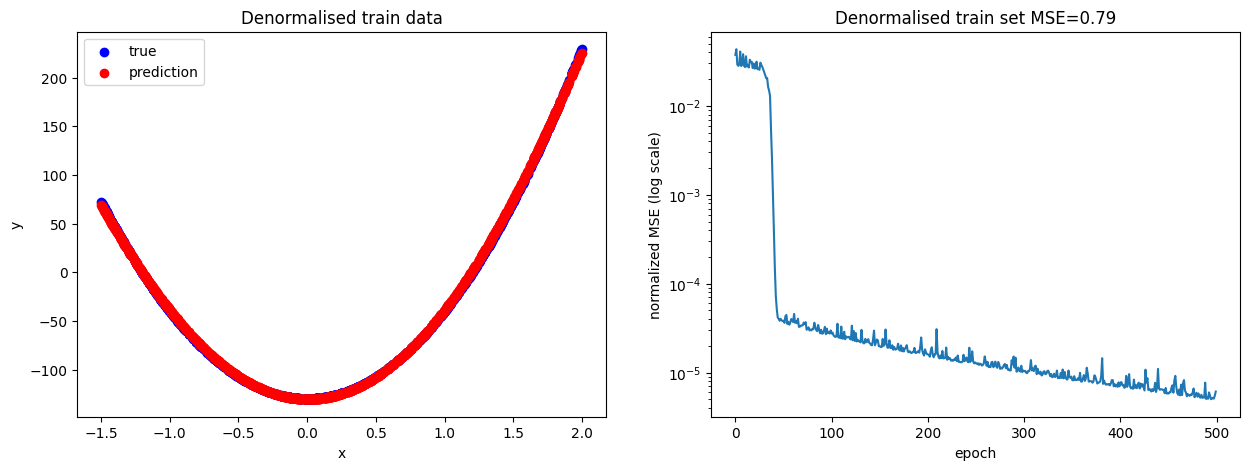

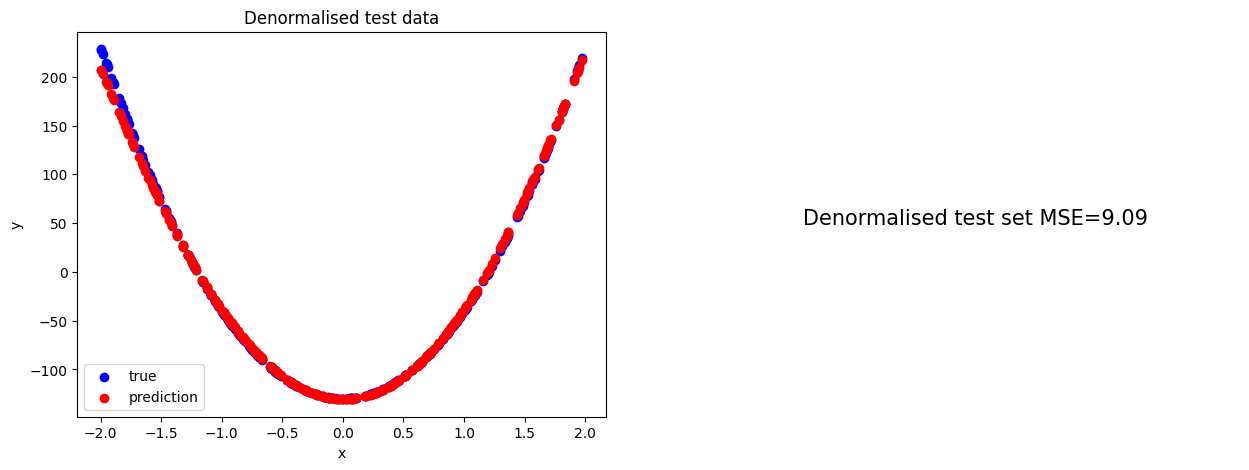

In [91]:
model_std = copy.deepcopy(model)
losses_std, _, _ = train_and_draw_plots(model_std, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=10)

## SGD with momentum

Epoch 1: loss_fun=0.055252045555620105
Epoch 10: loss_fun=6.4325849911306e-05
Epoch 20: loss_fun=1.5963668530223716e-05
Epoch 30: loss_fun=8.301600216796577e-06
Epoch 40: loss_fun=4.24514380403376e-06
Epoch 50: loss_fun=4.889856189532264e-06
Epoch 60: loss_fun=2.912582895275704e-06
Epoch 70: loss_fun=2.208139339381423e-06
Epoch 80: loss_fun=9.94263962410646e-07
Epoch 90: loss_fun=9.577014493926114e-07
Epoch 100: loss_fun=8.982207233466578e-07
Epoch 110: loss_fun=5.592055691674258e-07
Epoch 120: loss_fun=5.654186095325952e-07
Epoch 130: loss_fun=7.877456789230932e-07
Epoch 140: loss_fun=8.605206690742325e-07
Epoch 150: loss_fun=6.217361081417227e-07
Epoch 160: loss_fun=9.170875064418189e-07
Epoch 170: loss_fun=6.491884451640538e-07
Epoch 180: loss_fun=7.640849220800884e-07
Epoch 190: loss_fun=7.245192947830332e-07
Epoch 200: loss_fun=5.686309300991894e-07
Epoch 210: loss_fun=1.1043169375472384e-06
Epoch 220: loss_fun=4.936732351356981e-07
Epoch 230: loss_fun=4.843585336820538e-07
Epoch 

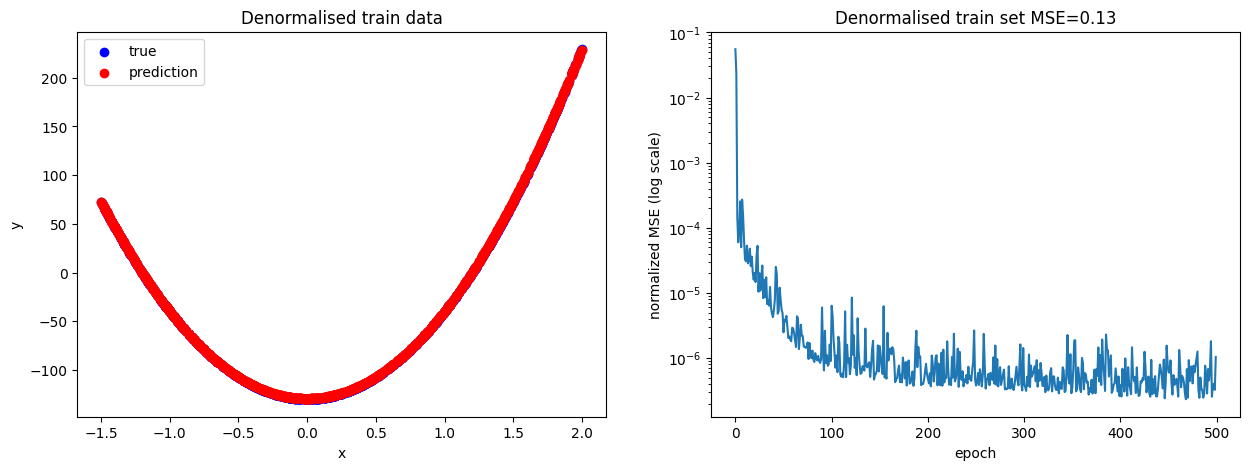

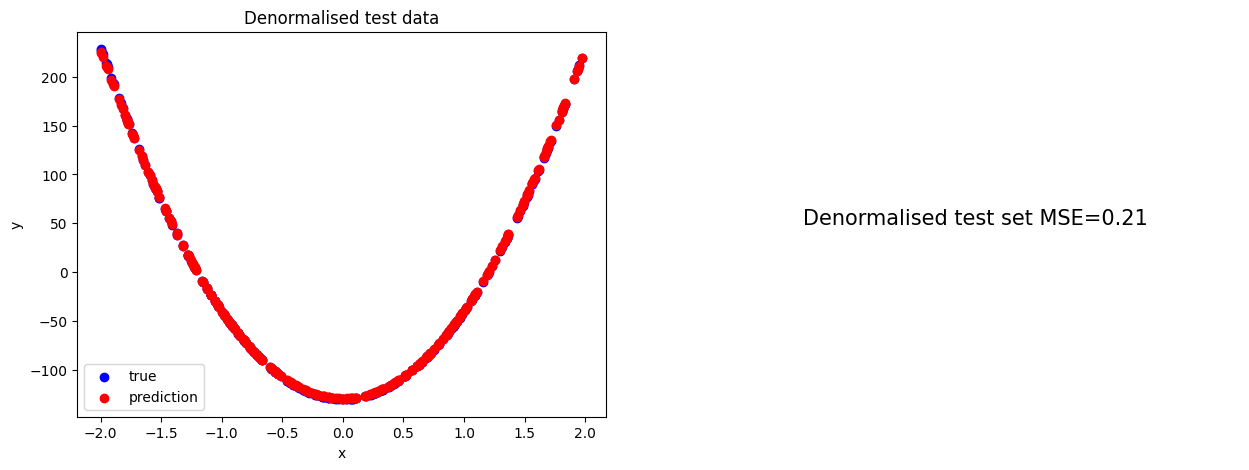

In [92]:
model_mom = copy.deepcopy(model)
losses_mom, _, _ = train_and_draw_plots(model_mom, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=10, momentum_coef=0.9, optimizer='momentum')

## SGD with RMSProp

Epoch 1: loss_fun=0.028459193117749675
Epoch 10: loss_fun=0.00010007255136746687
Epoch 20: loss_fun=6.686858324380065e-05
Epoch 30: loss_fun=4.720929813417754e-05
Epoch 40: loss_fun=4.81794956399654e-05
Epoch 50: loss_fun=0.00010640079437914322
Epoch 60: loss_fun=1.8924938076399515e-05
Epoch 70: loss_fun=5.8710169207695603e-05
Epoch 80: loss_fun=2.5004914541908112e-05
Epoch 90: loss_fun=1.1126618765094536e-05
Epoch 100: loss_fun=8.038159391737354e-06
Epoch 110: loss_fun=5.970471534274815e-06
Epoch 120: loss_fun=5.94902074314661e-05
Epoch 130: loss_fun=4.916022062044376e-06
Epoch 140: loss_fun=3.4240499885633267e-06
Epoch 150: loss_fun=3.0367350548356615e-06
Epoch 160: loss_fun=2.734322375121049e-06
Epoch 170: loss_fun=3.6976014308008424e-06
Epoch 180: loss_fun=4.399690744345241e-06
Epoch 190: loss_fun=3.343995190826319e-06
Epoch 200: loss_fun=1.7952288069700322e-06
Epoch 210: loss_fun=1.9024557475859476e-06
Epoch 220: loss_fun=2.03896501471903e-06
Epoch 230: loss_fun=1.5576082306825706

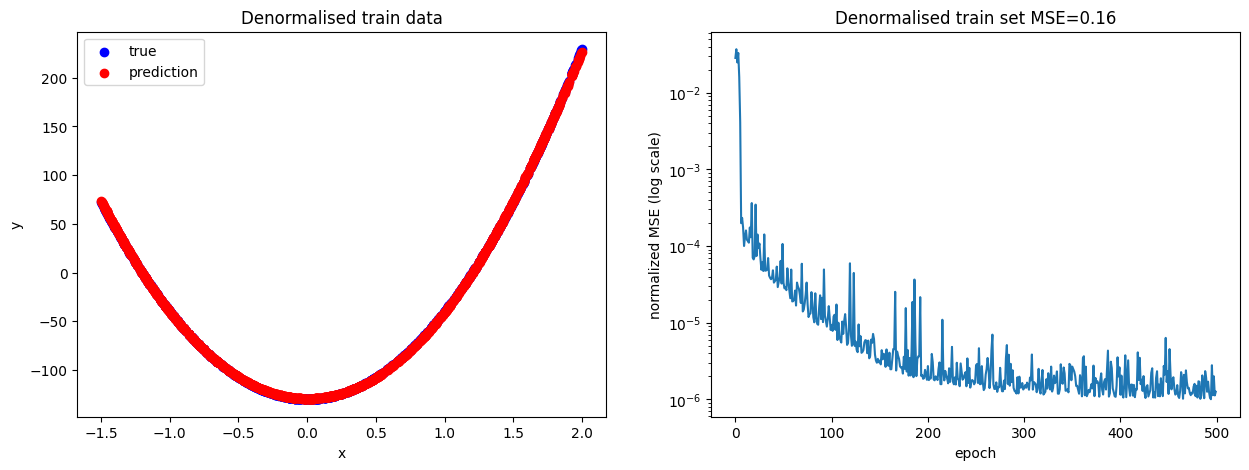

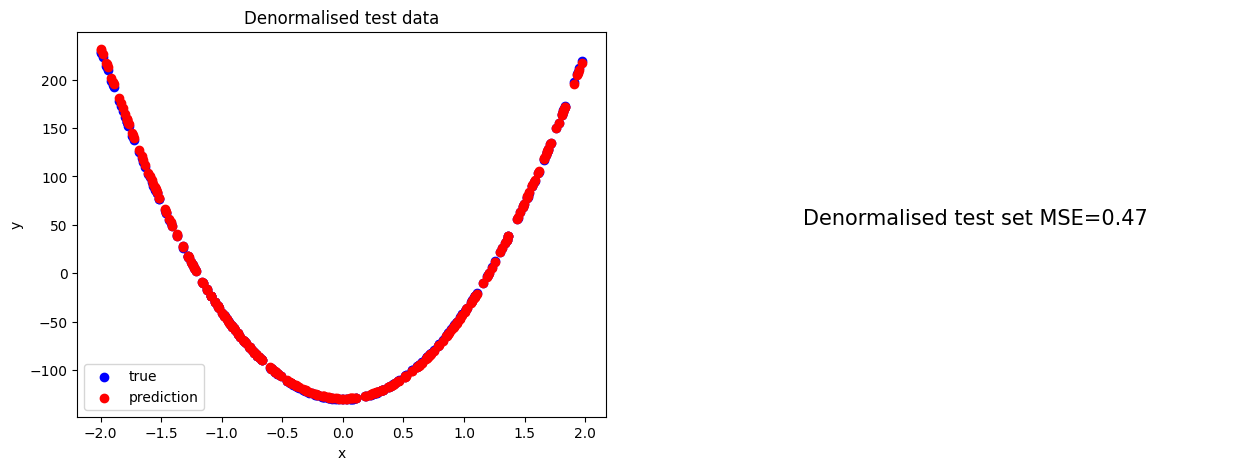

In [112]:
model_rms = copy.deepcopy(model)
losses_rms, _, _ = train_and_draw_plots(model_rms, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=10, beta=0.90, epsilon=0.05, optimizer='RMSProp')

## Convergence speed comparison

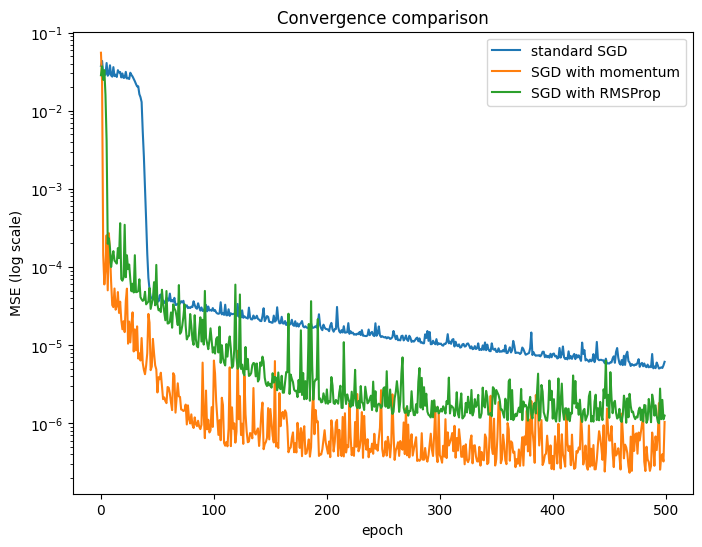

In [114]:
fig, ax = plt.subplots(figsize=(8, 6))

x = range(epochs)
ax.plot(x, losses_std, label='standard SGD')
ax.plot(x, losses_mom, label='SGD with momentum')
ax.plot(x, losses_rms, label='SGD with RMSProp')
ax.set_yscale('log')

ax.set_xlabel('epoch')
ax.set_ylabel('MSE (log scale)')
ax.set_title('Convergence comparison')
ax.legend()
plt.show()


# Steps-large

In [21]:
import pandas as pd

In [22]:
X_train = pd.read_csv('data/regression/steps-large-training.csv', index_col=0)['x']
Y_train = pd.read_csv('data/regression/steps-large-training.csv', index_col=0)['y']
X_test = pd.read_csv('data/regression/steps-large-test.csv', index_col=0)['x']
Y_test = pd.read_csv('data/regression/steps-large-test.csv', index_col=0)['y']

In [23]:
model = MLP([1, 5, 1], 'sigmoid')

In [24]:
epochs = 10000
first_lr = 0.1
lr_decay_rate = 1e-4

## Standard SGD

Epoch 1: loss_fun=0.004571596199028275
Epoch 2: loss_fun=0.004561784427940753
Epoch 3: loss_fun=0.004298872440846833
Epoch 4: loss_fun=0.004476301911612811
Epoch 5: loss_fun=0.004222437250277578
Epoch 6: loss_fun=0.004848020750425528
Epoch 7: loss_fun=0.004288829749581464
Epoch 8: loss_fun=0.004199814387053075
Epoch 9: loss_fun=0.005954239766550705
Epoch 10: loss_fun=0.004204762534955425
Epoch 11: loss_fun=0.00415576070733695
Epoch 12: loss_fun=0.004164092450679198
Epoch 13: loss_fun=0.005464524627393518
Epoch 14: loss_fun=0.004159780764762035
Epoch 15: loss_fun=0.004194380907384919
Epoch 16: loss_fun=0.0063683442922865124
Epoch 17: loss_fun=0.004310658760255946
Epoch 18: loss_fun=0.004822218572722413
Epoch 19: loss_fun=0.004218744687722933
Epoch 20: loss_fun=0.004164998683314701
Epoch 21: loss_fun=0.005347443444199394
Epoch 22: loss_fun=0.004302264662345898
Epoch 23: loss_fun=0.004523693641673131
Epoch 24: loss_fun=0.004172456125591285
Epoch 25: loss_fun=0.00508680709859549
Epoch 26: 

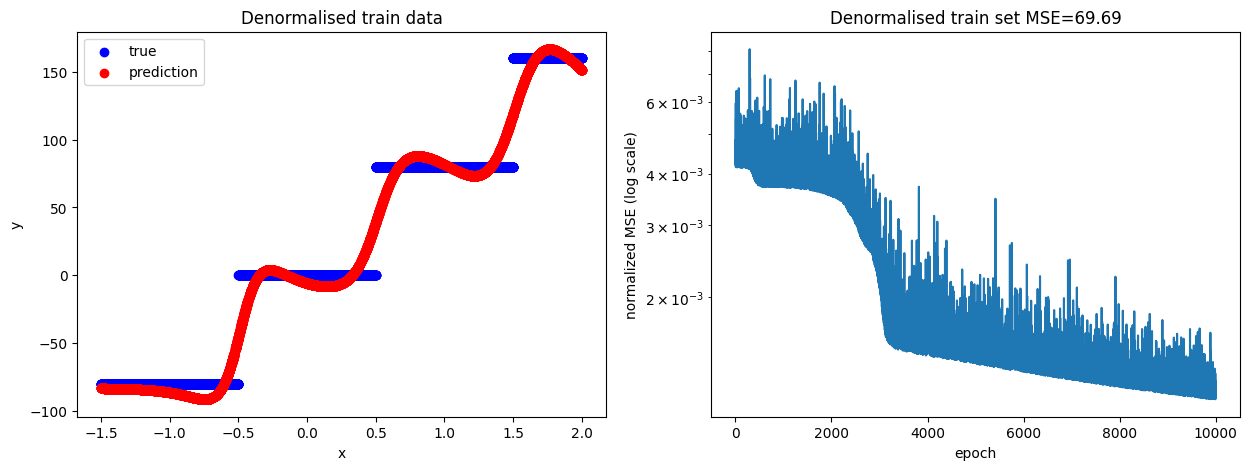

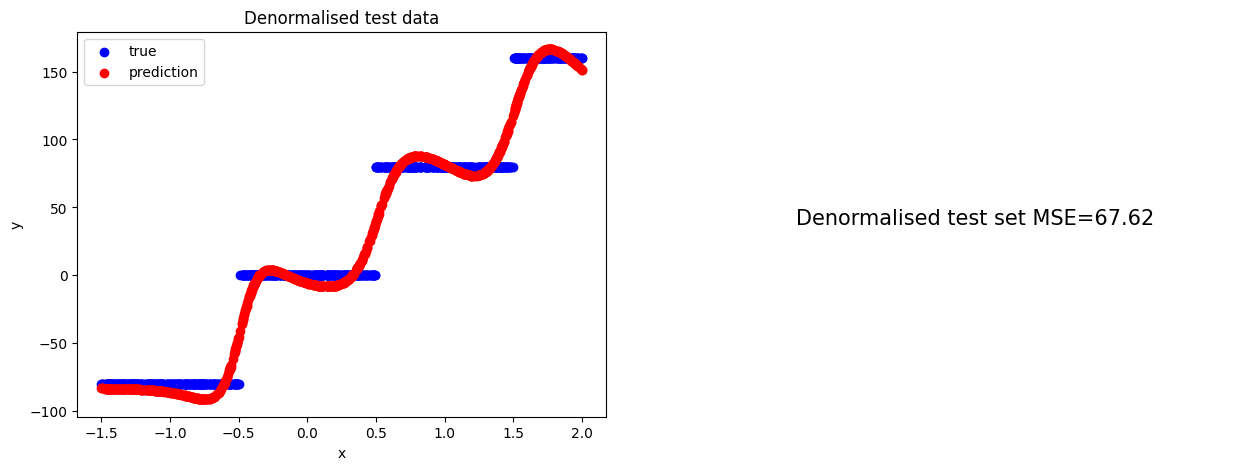

In [25]:
model_std = copy.deepcopy(model)
losses_std, _, _ = train_and_draw_plots(model_std, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=1, lr_decay_rate=lr_decay_rate)

## SGD with momentum

Epoch 1: loss_fun=0.005727714727446028
Epoch 2: loss_fun=0.007374472414416335
Epoch 3: loss_fun=0.00434734424753809
Epoch 4: loss_fun=0.0068306342957543936
Epoch 5: loss_fun=0.005487406643544845
Epoch 6: loss_fun=0.00499784180651889
Epoch 7: loss_fun=0.007948961341710734
Epoch 8: loss_fun=0.004379008067421027
Epoch 9: loss_fun=0.004326561518975808
Epoch 10: loss_fun=0.004862632794383725
Epoch 11: loss_fun=0.007025199173537933
Epoch 12: loss_fun=0.00917689334673813
Epoch 13: loss_fun=0.004683631764240721
Epoch 14: loss_fun=0.004828689046609437
Epoch 15: loss_fun=0.005107136916915364
Epoch 16: loss_fun=0.005267085787859184
Epoch 17: loss_fun=0.004606678006797864
Epoch 18: loss_fun=0.00616453305889866
Epoch 19: loss_fun=0.0076847622603227845
Epoch 20: loss_fun=0.004386360369473623
Epoch 21: loss_fun=0.005921596814423104
Epoch 22: loss_fun=0.00474151702579677
Epoch 23: loss_fun=0.005084294194978907
Epoch 24: loss_fun=0.004387649566812216
Epoch 25: loss_fun=0.006786997043583963
Epoch 26: lo

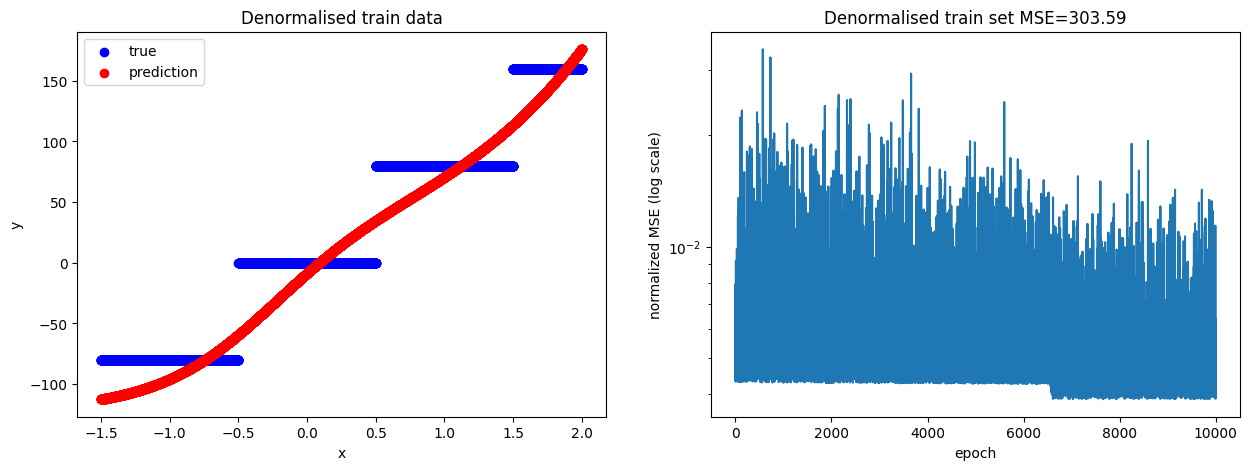

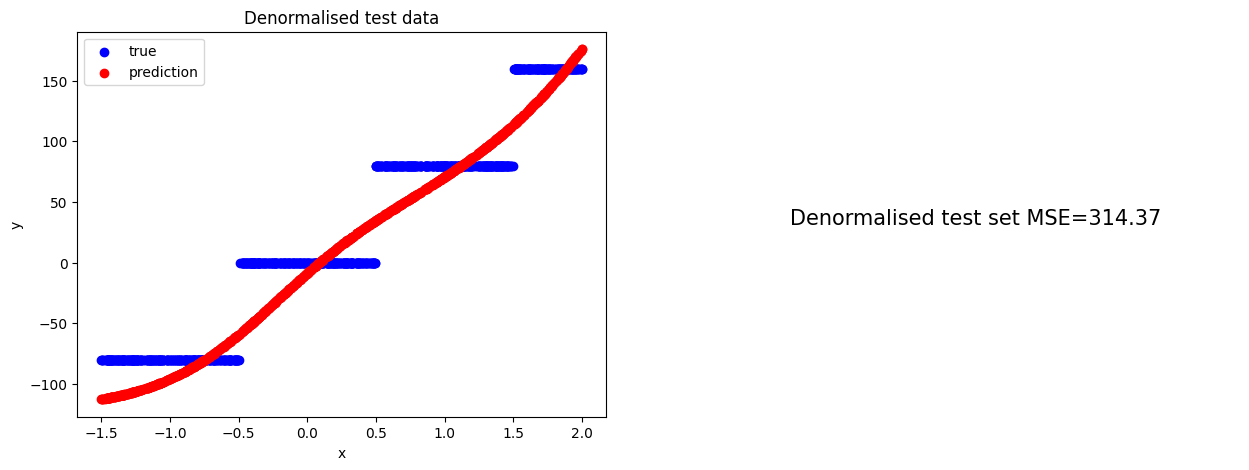

In [26]:
model_mom = copy.deepcopy(model)
losses_mom, _, _ = train_and_draw_plots(model_mom, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=1, momentum_coef=0.9, optimizer='momentum', lr_decay_rate=lr_decay_rate)

## SGD with RMSProp

Epoch 1: loss_fun=0.007243174146922991
Epoch 2: loss_fun=0.006811283123698768
Epoch 3: loss_fun=0.004184095570023096
Epoch 4: loss_fun=0.005790855619101609
Epoch 5: loss_fun=0.004832094329412302
Epoch 6: loss_fun=0.004554679789570264
Epoch 7: loss_fun=0.004320221781641363
Epoch 8: loss_fun=0.005910571519059879
Epoch 9: loss_fun=0.009568228034116564
Epoch 10: loss_fun=0.004981173930322264
Epoch 11: loss_fun=0.007495958596487748
Epoch 12: loss_fun=0.008098902307295729
Epoch 13: loss_fun=0.004633723109777049
Epoch 14: loss_fun=0.004789717031560813
Epoch 15: loss_fun=0.004242279507505074
Epoch 16: loss_fun=0.007448471269505962
Epoch 17: loss_fun=0.0046853539918349455
Epoch 18: loss_fun=0.004711250195059037
Epoch 19: loss_fun=0.004831253083356609
Epoch 20: loss_fun=0.004528754165729605
Epoch 21: loss_fun=0.0047154984803944346
Epoch 22: loss_fun=0.005150465881711338
Epoch 23: loss_fun=0.00596489494154012
Epoch 24: loss_fun=0.005939678332422157
Epoch 25: loss_fun=0.006920839436428642
Epoch 26

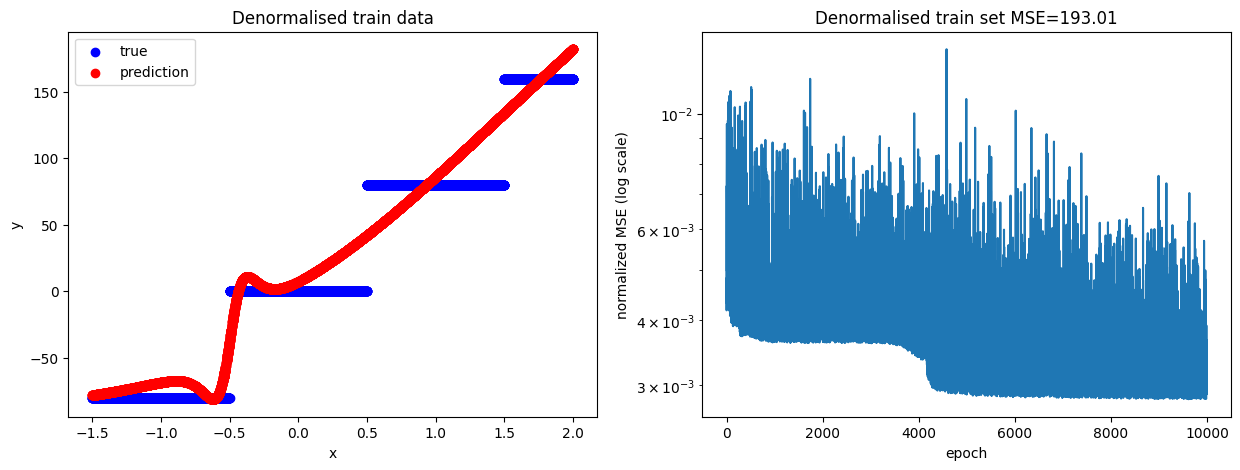

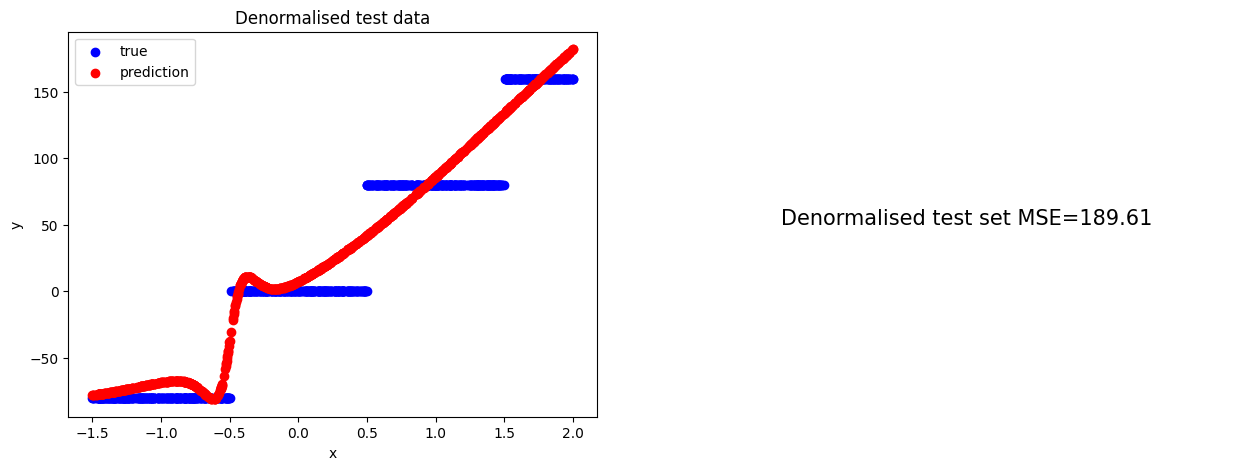

In [27]:
model_rms = copy.deepcopy(model)
losses_rms, _, _ = train_and_draw_plots(model_rms, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=1, beta=0.90, epsilon=0.05, optimizer='RMSProp', lr_decay_rate=lr_decay_rate)

## Convergence speed comparison

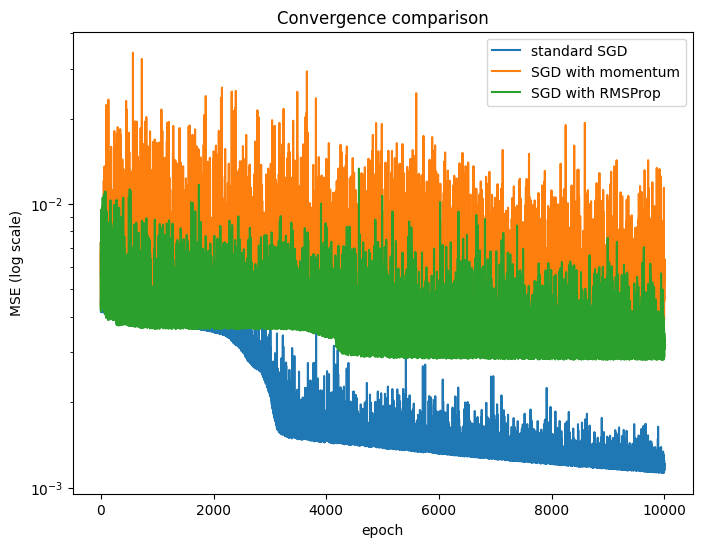

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

x = range(epochs)
ax.plot(x, losses_std, label='standard SGD')
ax.plot(x, losses_mom, label='SGD with momentum')
ax.plot(x, losses_rms, label='SGD with RMSProp')
ax.set_yscale('log')

ax.set_xlabel('epoch')
ax.set_ylabel('MSE (log scale)')
ax.set_title('Convergence comparison')
ax.legend()
plt.show()


# Multimodal-large

In [10]:
import pandas as pd

In [11]:
X_train = pd.read_csv('data/regression/multimodal-large-training.csv')['x']
Y_train = pd.read_csv('data/regression/multimodal-large-training.csv')['y']
X_test = pd.read_csv('data/regression/multimodal-large-test.csv')['x']
Y_test = pd.read_csv('data/regression/multimodal-large-test.csv')['y']

In [12]:
model = MLP([1, 10, 10, 1], 'sigmoid')

In [13]:
epochs = 1500
first_lr = 0.1
lr_decay_rate = 1e-3

## Standard SGD

Epoch 1: loss_fun=0.0724845201298287
Epoch 2: loss_fun=0.08289127319945909
Epoch 3: loss_fun=0.05809397739481794
Epoch 4: loss_fun=0.04948297136769543
Epoch 5: loss_fun=0.03331625689209866
Epoch 6: loss_fun=0.03282348445586161
Epoch 7: loss_fun=0.04165465757168898
Epoch 8: loss_fun=0.03294873992087347
Epoch 9: loss_fun=0.0277461009738867
Epoch 10: loss_fun=0.026063452206650788
Epoch 11: loss_fun=0.025107468178777678
Epoch 12: loss_fun=0.02688670178539346
Epoch 13: loss_fun=0.0363506894101913
Epoch 14: loss_fun=0.021920693518813806
Epoch 15: loss_fun=0.02090817834821541
Epoch 16: loss_fun=0.02062130615876477
Epoch 17: loss_fun=0.01879278647716646
Epoch 18: loss_fun=0.017381223997559467
Epoch 19: loss_fun=0.01662990387686155
Epoch 20: loss_fun=0.014206583093738706
Epoch 21: loss_fun=0.012446925982476638
Epoch 22: loss_fun=0.010079640146763408
Epoch 23: loss_fun=0.01140630416386922
Epoch 24: loss_fun=0.010592881622420143
Epoch 25: loss_fun=0.012402461423353944
Epoch 26: loss_fun=0.0115225

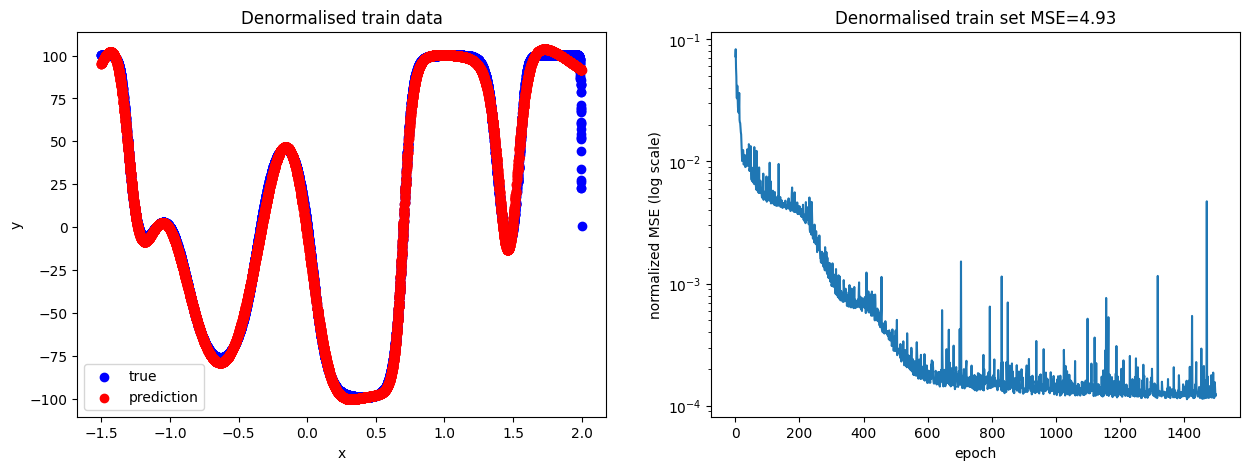

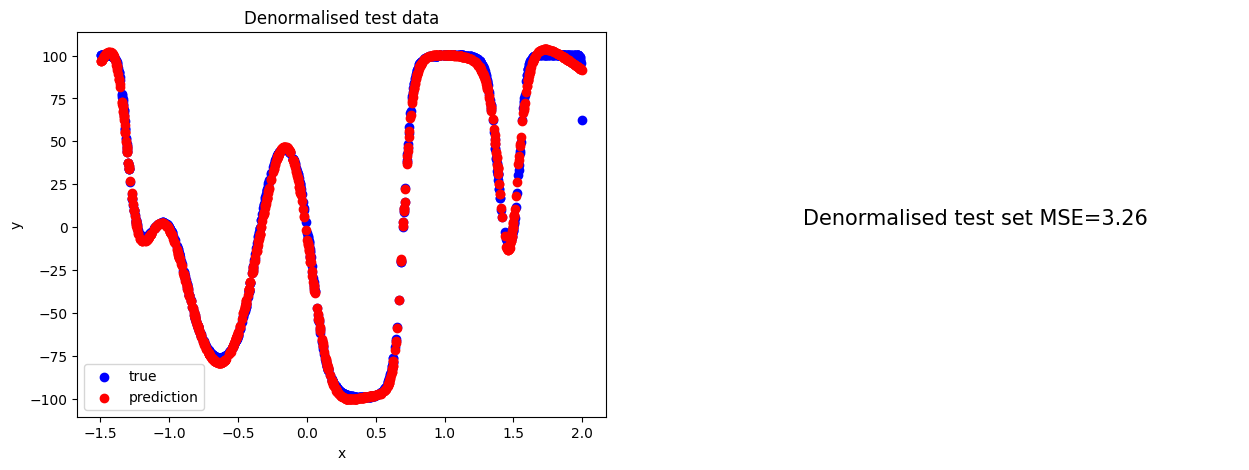

In [15]:
model_std = copy.deepcopy(model)
losses_std, _, _ = train_and_draw_plots(model_std, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=1)

## SGD with momentum

Epoch 1: loss_fun=0.05612756740677836
Epoch 2: loss_fun=0.056952467165817505
Epoch 3: loss_fun=0.031374059436331134
Epoch 4: loss_fun=0.030897377597838716
Epoch 5: loss_fun=0.0405185158895576
Epoch 6: loss_fun=0.02557679577050617
Epoch 7: loss_fun=0.02542363466657049
Epoch 8: loss_fun=0.03045289100064374
Epoch 9: loss_fun=0.04278426121778636
Epoch 10: loss_fun=0.023885588047468986
Epoch 11: loss_fun=0.05920282821672721
Epoch 12: loss_fun=0.03462668439973833
Epoch 13: loss_fun=0.02934541373732975
Epoch 14: loss_fun=0.04132157320346381
Epoch 15: loss_fun=0.03192164948916531
Epoch 16: loss_fun=0.016816187778772137
Epoch 17: loss_fun=0.02301253229230636
Epoch 18: loss_fun=0.013830119053331402
Epoch 19: loss_fun=0.011606083659333154
Epoch 20: loss_fun=0.007268329335308502
Epoch 21: loss_fun=0.007388106410418735
Epoch 22: loss_fun=0.007383461272706287
Epoch 23: loss_fun=0.014973436530992867
Epoch 24: loss_fun=0.006489358419212968
Epoch 25: loss_fun=0.007741918999417994
Epoch 26: loss_fun=0.0

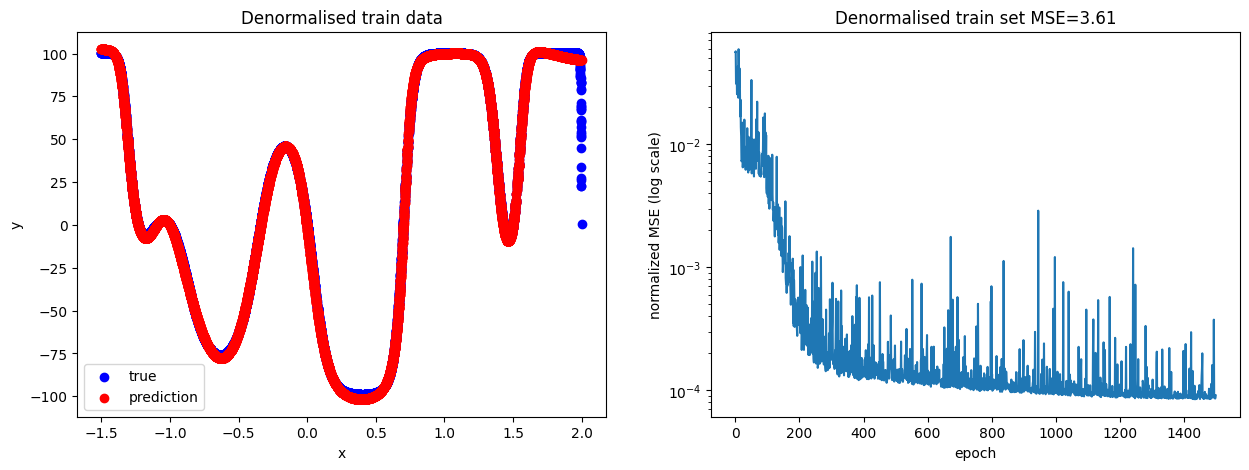

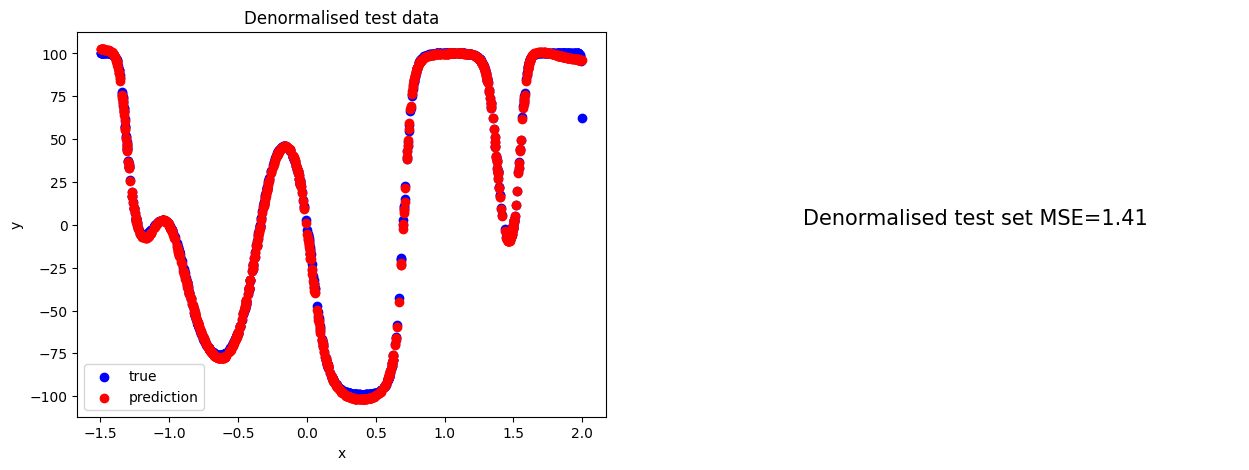

In [16]:
model_mom = copy.deepcopy(model)
losses_mom, _, _ = train_and_draw_plots(model_mom, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=1, momentum_coef=0.9, optimizer='momentum', lr_decay_rate=lr_decay_rate)

## SGD with RMSProp

Epoch 1: loss_fun=0.052440578915416106
Epoch 2: loss_fun=0.04700282015688442
Epoch 3: loss_fun=0.03683878148605736
Epoch 4: loss_fun=0.03354469515711807
Epoch 5: loss_fun=0.03436454676760823
Epoch 6: loss_fun=0.028296115438229952
Epoch 7: loss_fun=0.025746281040768672
Epoch 8: loss_fun=0.024695053919563704
Epoch 9: loss_fun=0.024568609073659785
Epoch 10: loss_fun=0.023401120213736772
Epoch 11: loss_fun=0.018023839708599804
Epoch 12: loss_fun=0.016131355804678036
Epoch 13: loss_fun=0.012419208839571346
Epoch 14: loss_fun=0.0158172669741504
Epoch 15: loss_fun=0.010435195727603565
Epoch 16: loss_fun=0.010452187091415432
Epoch 17: loss_fun=0.011115069719487725
Epoch 18: loss_fun=0.01208866886980216
Epoch 19: loss_fun=0.014972641636678136
Epoch 20: loss_fun=0.011975348052349363
Epoch 21: loss_fun=0.010762883604841145
Epoch 22: loss_fun=0.01194469199732603
Epoch 23: loss_fun=0.010230563619090083
Epoch 24: loss_fun=0.00964170681568886
Epoch 25: loss_fun=0.009874520777813632
Epoch 26: loss_fun

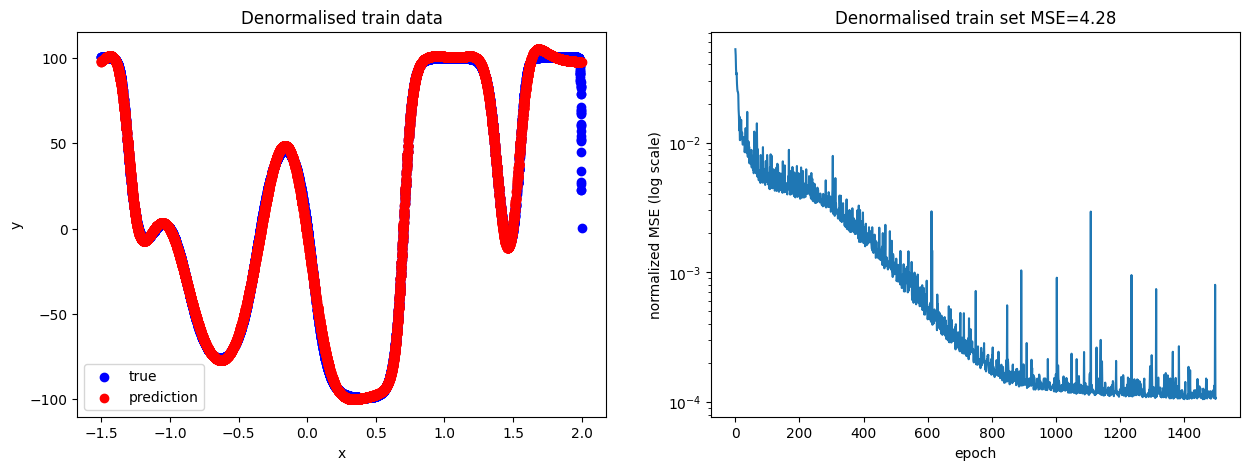

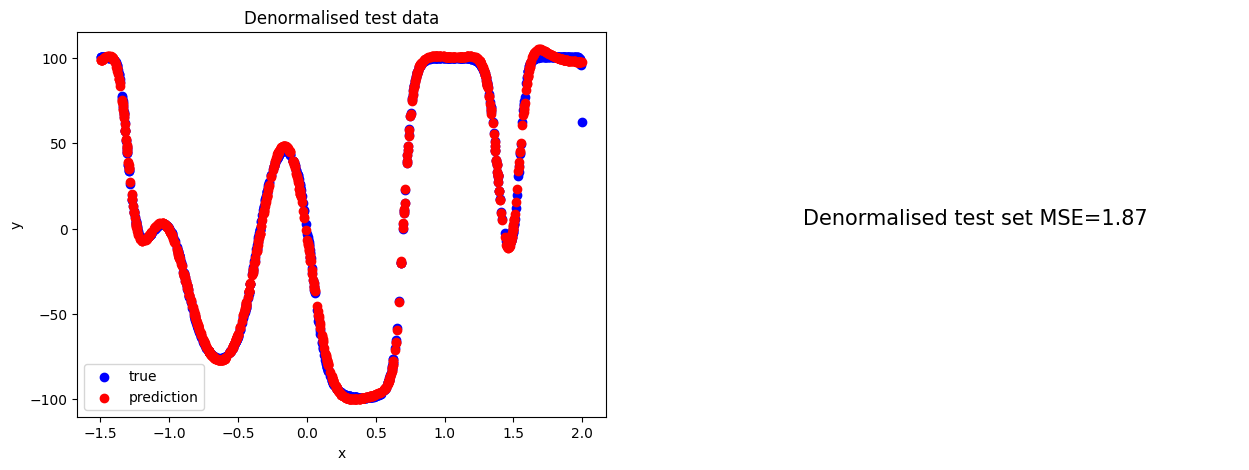

In [14]:
model_rms = copy.deepcopy(model)
losses_rms, _, _ = train_and_draw_plots(model_rms, X_train, Y_train, X_test, Y_test, method='sgd', first_lr=first_lr, epochs=epochs, n_epochs_displayed=1, beta=0.90, epsilon=0.5, optimizer='RMSProp')

## Convergence speed comparison

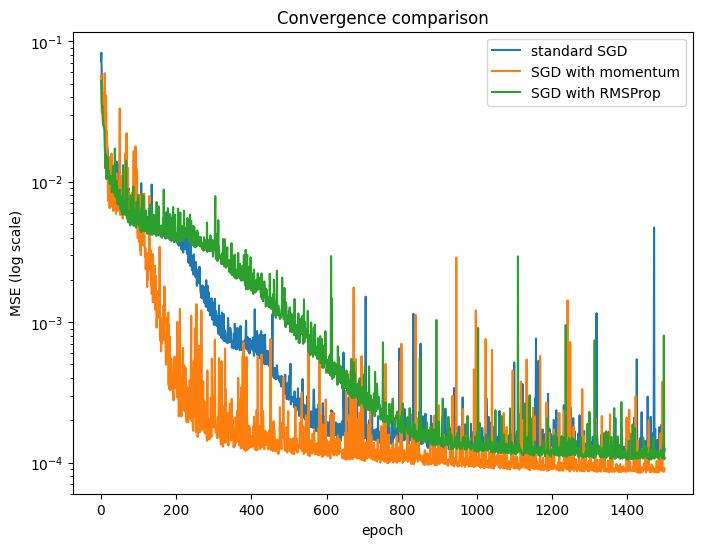

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

x = range(epochs)
ax.plot(x, losses_std, label='standard SGD')
ax.plot(x, losses_mom, label='SGD with momentum')
ax.plot(x, losses_rms, label='SGD with RMSProp')
ax.set_yscale('log')

ax.set_xlabel('epoch')
ax.set_ylabel('MSE (log scale)')
ax.set_title('Convergence comparison')
ax.legend()
plt.show()
